# Multivariate Time Series Forecasting and Feature Importance
This notebook introduces the steps to prepare a time series dataset, train a model for prediction, and calculate feature importance. 

More specifically, we would forecast BTC-USD price using the LSTM model from `Pytorch`, and find the feature importance using the `SHAP` library.

In [3]:
import numpy as np
import pandas as pd
import torch, ta
from datetime import datetime, timedelta
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import shap
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Data preparation
We will download our raw dataset from Yahoo Finance, and generate some technical features to improve the prediction quality using the `ta` library.

In [346]:
df = pd.read_csv('https://query1.finance.yahoo.com/v7/finance/download/BTC-USD?period1=0&period2=9999999999&interval=1d&events=history&includeAdjustedClose=true')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...,...
2906,2022-09-01,20050.498047,20198.390625,19653.968750,20127.140625,20127.140625,30182031010
2907,2022-09-02,20126.072266,20401.568359,19814.765625,19969.771484,19969.771484,29123998928
2908,2022-09-03,19969.718750,20037.009766,19698.355469,19832.087891,19832.087891,23613051457
2909,2022-09-04,19832.470703,19999.689453,19636.816406,19986.712891,19986.712891,25245861652


In [347]:
df['RSI'] = ta.momentum.rsi(df['Close']) / 100
df['ATR_over_price'] = ta.volatility.average_true_range(df['High'], df['Low'], df['Close']) / df['Close']
df['SO'] = ta.momentum.stoch(df['High'], df['Low'], df['Close']) / 100
df['MACD_over_price'] = ta.trend.macd(df['Close']) / df['Close']
df['vortex_pos'] = ta.trend.vortex_indicator_pos(df['High'], df['Low'], df['Close'])
df['vortex_neg'] = ta.trend.vortex_indicator_neg(df['High'], df['Low'], df['Close'])
df['MFI'] = ta.volume.money_flow_index(df['High'], df['Low'], df['Close'], df['Volume']) / 100
df['ADX'] = ta.trend.adx(df['High'], df['Low'], df['Close']) / 100
df['stochRSI'] = ta.momentum.stochrsi(df['Close'])
df['PVO'] = ta.momentum.pvo(df['Volume']) / 100
df['log_diff'] = np.log(df['Close']/df['Close'].shift(1))
df.dropna(inplace=True)
df_raw = df.copy()
df.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1, inplace=True)
df

invalid value encountered in double_scalars
invalid value encountered in double_scalars


,Date,RSI,ATR_over_price,SO,MACD_over_price,vortex_pos,vortex_neg,MFI,ADX,stochRSI,PVO,log_diff
26,2014-10-13,0.527398,0.064108,0.936885,-0.037002,0.990718,0.966638,0.620246,0.000000,1.000000,0.071120,0.030862
27,2014-10-14,0.562934,0.061769,0.911537,-0.026786,1.046637,0.940557,0.623919,0.427741,1.000000,0.062132,0.026429
28,2014-10-15,0.537552,0.060678,0.861726,-0.020762,1.019294,0.967940,0.578260,0.398381,0.930809,0.027081,-0.015326
29,2014-10-16,0.489887,0.062949,0.761916,-0.018523,0.997931,0.962573,0.572636,0.377587,0.800876,0.001884,-0.031436
30,2014-10-17,0.494635,0.060147,0.771736,-0.015739,1.044895,0.976518,0.588800,0.358277,0.813819,-0.050323,0.003137
...,...,...,...,...,...,...,...,...,...,...,...,...
2906,2022-09-01,0.374024,0.039593,0.145703,-0.040043,0.683027,1.301788,0.416877,0.263549,0.689515,0.029787,0.003852
2907,2022-09-02,0.363649,0.039154,0.167407,-0.040186,0.886997,1.299308,0.495758,0.264268,0.600858,0.021640,-0.007849
2908,2022-09-03,0.354387,0.037829,0.104941,-0.040422,0.873782,1.141896,0.502155,0.266326,0.521709,0.000484,-0.006918
2909,2022-09-04,0.373680,0.036152,0.175094,-0.039001,0.836788,1.184493,0.502523,0.268996,0.686578,-0.012168,0.007766


The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

- The width (number of time steps) of the input and label windows.
- The time offset between them.

Here are some examples:

1. To make a single prediction 24 days into the future, given 24 days of history, you might define a window like this:

  ![One prediction 24 days into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_24h.png?raw=1)

2. A model that makes a prediction one day into the future, given six days of history, would need a window like this:

  ![One prediction one day into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)
  
In this notebook, we would make a single prediction 7 days into the future, given 21 days of history. The variables `input_width` and `output_width` are set accordingly below.

In [348]:
input_width = 21
output_width = 7

train_factor = 0.8
train_len = int(len(df)*train_factor)
train_df = df.iloc[:train_len, :]
test_df = df.iloc[train_len:, :]

In [349]:
train_df

,Date,RSI,ATR_over_price,SO,MACD_over_price,vortex_pos,vortex_neg,MFI,ADX,stochRSI,PVO,log_diff
26,2014-10-13,0.527398,0.064108,0.936885,-0.037002,0.990718,0.966638,0.620246,0.000000,1.000000,0.071120,0.030862
27,2014-10-14,0.562934,0.061769,0.911537,-0.026786,1.046637,0.940557,0.623919,0.427741,1.000000,0.062132,0.026429
28,2014-10-15,0.537552,0.060678,0.861726,-0.020762,1.019294,0.967940,0.578260,0.398381,0.930809,0.027081,-0.015326
29,2014-10-16,0.489887,0.062949,0.761916,-0.018523,0.997931,0.962573,0.572636,0.377587,0.800876,0.001884,-0.031436
30,2014-10-17,0.494635,0.060147,0.771736,-0.015739,1.044895,0.976518,0.588800,0.358277,0.813819,-0.050323,0.003137
...,...,...,...,...,...,...,...,...,...,...,...,...
2329,2021-02-01,0.514825,0.090580,0.484910,0.009546,0.940888,1.062646,0.462112,0.211589,0.545512,0.024791,0.012688
2330,2021-02-02,0.568622,0.084279,0.693642,0.012945,0.939999,1.042991,0.463999,0.203830,1.000000,0.017850,0.057168
2331,2021-02-03,0.614403,0.078043,0.901176,0.019221,1.044117,0.973835,0.538205,0.201900,1.000000,0.009858,0.053774
2332,2021-02-04,0.595461,0.077941,0.827146,0.023632,1.154193,0.922525,0.618515,0.203553,0.896866,0.012750,-0.014679


Since we are using a moving window of 21 input days and 7 output days, we need to re-implement the `Dataset` class of `Pytorch` to accomodate our problem. There are 3 main functions that we must write:
* \_\_init\_\_: initialte the dataset and data widths.
* \_\_len\_\_: return the total length of our dataset
* \_\_getitem\_\_: return the data point at a given index.

In [350]:
class TSDataset(Dataset):   
    def __init__(self, data, input_width=21, output_width=7):
        # data columns needs to be in the order of ['Date', ta_features, 'log_difference']
        data = data[:, 1:].astype(float) # remove the 'Date' column
        data = torch.Tensor(data)
        self.data = data
        self.input_width = input_width
        self.output_width = output_width

    def __len__(self):
        return self.data.shape[0] - self.input_width - self.output_width

    def __getitem__(self, index):
        cut_point = index + self.input_width
        return self.data[index : cut_point], self.data[cut_point : cut_point+self.output_width, -1]

## Model training
In this example, we use the following model architecture:
* 2-layer LSTM, with hidden layer size = 64
* LSTM dropout rate = 0.5
* The final hidden layer is then fed into a fully connected layer with output size = 7, which corresponds to our `output_width`.

This is an arbitrary choice of architecture for demonstration purpose only. For production systems, more experiments would be needed to find out the optimal model.

In [351]:
class TSModel(nn.Module):
    def __init__(self, n_features, output_width, n_hidden=64, n_layers=2):
        super(TSModel, self).__init__()

        self.n_hidden = n_hidden
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            batch_first=True,
            num_layers=n_layers,
            dropout=0.5
        )
        self.linear = nn.Linear(n_hidden, output_width)
        
    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        lstm_out = hidden[-1]  # output last hidden state output
        y_pred = self.linear(lstm_out)
        
        return y_pred

In [352]:
def train_model(
        train_df,
        test_df,
        output_width,
        batch_size,
        n_epochs,
        n_epochs_stop
):
    print('Begin model training.')
    # create dataloaders
    train_dataset = TSDataset(train_df.values)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    test_dataset = TSDataset(test_df.values)
    test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

    # set up training
    n_features = train_df.shape[1] - 1 # Not counting the 'date' column
    model = TSModel(n_features=n_features, output_width=output_width)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_hist = []
    test_hist = []

    # start training
    best_loss = np.inf
    epochs_no_improve = 0
    for epoch in range(1, n_epochs+1):
        running_loss = 0
        model.train()

        for batch_idx, (data, target) in enumerate(train_loader, 1):
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            output = model(data)
            loss = criterion(output, target.type_as(output))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        running_loss /= len(train_loader)
        train_hist.append(running_loss)

        # test loss
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                loss = criterion(output, target.type_as(output))
                test_loss += loss.item()
            test_loss /= len(test_loader)
            test_hist.append(test_loss)

            # early stopping
            if test_loss < best_loss:
                best_loss = test_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            if epochs_no_improve == n_epochs_stop:
                print("Early stopping.")
                break

        print(f'Epoch {epoch} train loss: {round(running_loss, 6)} test loss: {round(test_loss, 6)}')

        hist = pd.DataFrame()
        hist['training_loss'] = train_hist
        hist['test_loss'] = test_hist

    print("Completed.")

    return hist, model

In [353]:
batch_size = 8
n_epochs = 20
n_epochs_stop = 5
model_dir = '../model/'

In [354]:
hist, model = train_model(train_df, test_df, output_width, batch_size, n_epochs, n_epochs_stop)

Begin model training.
Epoch 1 train loss: 0.001661 test loss: 0.00155
Epoch 2 train loss: 0.001561 test loss: 0.001507
Epoch 3 train loss: 0.001552 test loss: 0.001498
Epoch 4 train loss: 0.001549 test loss: 0.001485
Epoch 5 train loss: 0.001546 test loss: 0.001482
Epoch 6 train loss: 0.001546 test loss: 0.001482
Epoch 7 train loss: 0.001545 test loss: 0.001477
Epoch 8 train loss: 0.001543 test loss: 0.001473
Epoch 9 train loss: 0.001543 test loss: 0.001473
Epoch 10 train loss: 0.001543 test loss: 0.001468
Epoch 11 train loss: 0.001543 test loss: 0.001464
Epoch 12 train loss: 0.001542 test loss: 0.001462
Epoch 13 train loss: 0.001542 test loss: 0.001461
Epoch 14 train loss: 0.001541 test loss: 0.00146
Epoch 15 train loss: 0.00154 test loss: 0.001459
Epoch 16 train loss: 0.00154 test loss: 0.001456
Epoch 17 train loss: 0.001541 test loss: 0.001456
Epoch 18 train loss: 0.001539 test loss: 0.001453
Epoch 19 train loss: 0.001539 test loss: 0.001454
Epoch 20 train loss: 0.001538 test loss: 

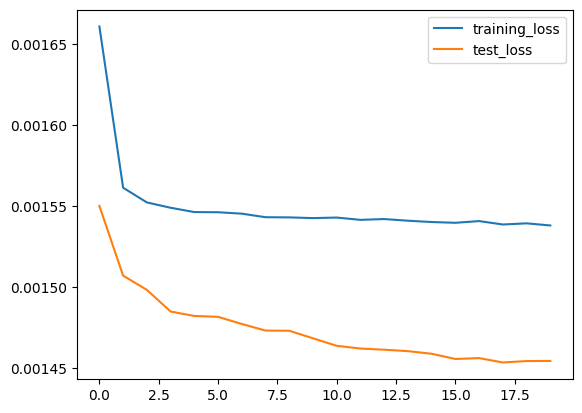

In [356]:
hist.plot()
plt.show()

## Playing around with the model
The chart below displays our test dataset. You can take a closer look at how good the generated forecasts are by the following steps:
* Pick any date within the test range
* Run the cell below the chart (the one with the `while` loop), and input the selected date.

In [333]:
date_list = df_raw['Date'].values.tolist()[train_len : -(input_width + output_width)]
first_date = date_list[0]
last_date = date_list[-1]
pred_point_start = date_list[input_width]
pred_point_end = date_list[-output_width]

px.line(df_raw.query('Date >= @first_date and Date <= @last_date'),
        x='Date',
        y='Adj Close'
)

In [334]:
while True:
    print('Enter a date from which to generate predictions.')
    print(f'The date should be between {pred_point_start} and {pred_point_end}, and in "yyyy-mm-dd" format.')
    print('Enter "stop" to exit the loop.')
    date = input() # input a date with yyyy-mm-dd format
    if date == 'stop':
        break
    try:
        assert date in date_list[input_width:-output_width]
    except:
        print("[Error]: Please input a date in the valid range.")
        continue
    clear_output(wait=True)
    date = (datetime.strptime(date, '%Y-%m-%d') - timedelta(days=input_width)).strftime('%Y-%m-%d')
    tmp_df = df_raw.query('Date >= @date')[:(input_width + output_width)]
    input_data = torch.tensor(tmp_df.values[:input_width][:, 7:].astype('float32'))
    input_data = input_data.unsqueeze(dim=0)
    prediction = model(input_data)

    # Since the prediction is change percentate, we need to convert it 
    # to normal value
    initial_value = tmp_df[:input_width]['Adj Close'].values[-1]
    y_pred = [initial_value]
    for p in prediction[0, :]:
        y_pred.append(y_pred[-1] * np.exp(p.detach().numpy()))
    
    y_true = tmp_df[-(output_width+1):]['Adj Close'].values
    initial_data = tmp_df[:input_width]['Adj Close'].values

    tmp_df.loc[tmp_df.index[-(output_width+1):], 'actual'] = y_true
    tmp_df.loc[tmp_df.index[:input_width], 'initial_data'] = initial_data
    tmp_df.loc[tmp_df.index[-(output_width+1):], 'prediction'] = y_pred
    fig = px.line(tmp_df, x='Date', y=['initial_data', 'prediction', 'actual'])
    fig.show()
    mape = np.round(np.mean(abs((y_true - y_pred)/y_true)), 3)*100
    print(f'MAPE: {mape}%')

MAPE: 2.8000000000000003%
Enter a date from which to generate predictions.
The date should be between 2021-02-27 and 2022-08-02, and in "yyyy-mm-dd" format.
Enter "stop" to exit the loop.
stop


## Feature importance using SHAP
We use an approach that is based on the DeepLIFT algorithm, which approximates the SHAP values known from classic game theory. Basically, this approach seeks to answer the question of how much a feature contributes to a model’s predictions when it’s there (in the inputs) compared to when it’s not there (not in the inputs), thus deriving the feature’s importance. For more detail on how the method works, please refer to this paper from the author of the package: https://arxiv.org/abs/1705.07874

We use 1000 training data samples as the background dataset and 100 test data samples on which to explain the model’s output. Since the feature importances are calculated for each input sample at each time step on each day, we average them across all 100 input samples and 7 days, and plot the importances by feature as well as by time step.

In [357]:
# get background dataset
train_dataset = TSDataset(train_df.values)
background_train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=False)
background_data, _ = next(iter(background_train_loader))

# get test data samples on which to explain the model’s output
test_dataset = TSDataset(test_df.values)
sample_test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)
test_sample_data, _ = next(iter(sample_test_loader))

# integrate out feature importances based on background dataset
e = shap.DeepExplainer(model, background_data)

# explain the model's outputs on some data samples
shap_values = e.shap_values(test_sample_data)
shap_values = np.absolute(shap_values)
shap_values = np.mean(shap_values, axis=(0, 1)) # Averaging the result on all input samples and output date


Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [358]:
shap_plot = pd.DataFrame(shap_values, columns=list(df)[1:])
shap_plot['days'] = [i - input_width - 1 for i in list(range(1, input_width + 1))]
shap_plot.head()

,RSI,ATR_over_price,SO,MACD_over_price,vortex_pos,vortex_neg,MFI,ADX,stochRSI,PVO,log_diff,days
0,4.614726e-10,5.877890e-10,1.467858e-09,1.597822e-09,1.744823e-09,3.630496e-09,3.963973e-09,9.029388e-10,3.038225e-09,1.279672e-09,7.158733e-10,-21
1,1.057710e-09,1.037404e-09,3.113509e-09,2.655457e-09,2.832683e-09,6.475627e-09,7.201801e-09,1.619219e-09,8.103266e-09,1.984228e-09,1.308776e-09,-20
2,2.308124e-09,1.808492e-09,6.724277e-09,4.501965e-09,4.587796e-09,1.133558e-08,1.352692e-08,2.801463e-09,1.945247e-08,3.402282e-09,2.543910e-09,-19
3,4.556517e-09,3.406090e-09,1.437921e-08,7.740922e-09,8.459663e-09,1.948470e-08,2.617473e-08,4.591732e-09,4.201831e-08,7.010543e-09,5.391205e-09,-18
4,8.223714e-09,6.523664e-09,2.933855e-08,1.380393e-08,1.736874e-08,3.339588e-08,5.111617e-08,6.918459e-09,8.155369e-08,1.481634e-08,1.176332e-08,-17


In [362]:
shap_plot.mean().sort_values(ascending=False)

stochRSI            0.000074
MFI                 0.000063
SO                  0.000043
vortex_neg          0.000035
PVO                 0.000028
vortex_pos          0.000028
MACD_over_price     0.000018
RSI                 0.000014
ADX                 0.000014
log_diff            0.000013
ATR_over_price      0.000012
days              -11.000000
dtype: float64

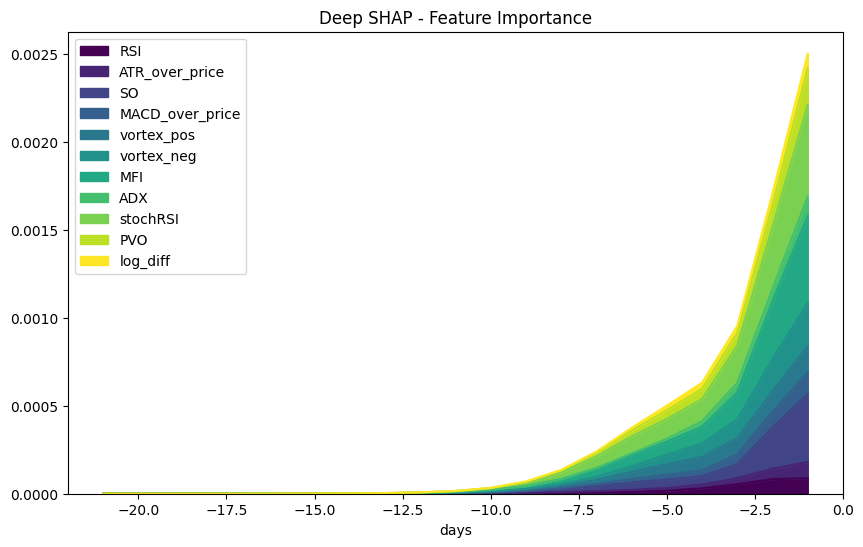

In [359]:
shap_plot.plot.area(x='days',figsize=(10, 6), cmap='viridis')
plt.title("Deep SHAP - Feature Importance")
plt.show()

The top 3 input features are Stochastic RSI, Money Flow Index, and Stochastic Oscillator. We can also see that more recent time steps, days -10 to -1, play a more significant role in making predictions compared to time steps further away, days -21 to -11, where day 0 is the time of prediction.